<font color="firebrick" size="6"><b>키워드 평균 가격 구하기 </b></font>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import requests
import time
import os

In [2]:
os.chdir("../../../smartstore") # signaturehelper module 호출하기 위해 경로 설정

In [3]:
data = pd.read_csv("conditionedData/data/2_sort_requests.csv")
keywords = data["relative_keyword"]

In [4]:
data.describe()

,total_search,total_store_count,competitive_rate
count,27678.000000,27678.000000,27678.000000
mean,5115.545198,20303.918058,7.635141
std,5398.870127,26463.303144,13.100292
min,1010.000000,1.000000,0.000000
25%,1670.000000,1160.000000,0.320000
50%,2940.000000,7624.000000,1.990000
75%,6160.000000,30283.250000,8.697500
max,29980.000000,105909.000000,102.150000


In [5]:
pd.options.display.max_rows = None  
keywords

0                                앱코키보드
1                               키즈경량패딩
2                             후쿠오카버스투어
3                                 식전영상
4                                면세점가방
5                                면세점향수
6                              면세점선글라스
7                              꾸셀파운데이션
8                                롱샴면세점
9                            인천공항면세점향수
10                         인천공항면세점선글라스
11                               면세점시계
12                             면세점가방추천
13                               면세점어그
14                           꾸셀베이스오리지널
15                              면세점립스틱
16                            면세점립스틱추천
17                              면세점화장품
18                             면세점향수추천
19                               어그면세점
20                               밍크엘레팡
21                               면세점지갑
22                           인천공항면세점롱샴
23                              마라톤싱글렛
24                             스포벨러닝벨트
25                       

**이상치 처리**

In [6]:
# 사분위수
def get_outlier(price_arr, weight=1.5):
  # target 값과 상관관계가 높은 열을 우선적으로 진행
    quantile_25 = np.percentile(price_arr, 25)
    quantile_75 = np.percentile(price_arr, 75)

    IQR = quantile_75 - quantile_25
    IQR_weight = IQR*weight
  
    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight
  
    excluded_prices = price_arr[(price_arr < lowest) | (price_arr > highest)]
    price_arr = price_arr[(price_arr >=lowest) & (price_arr <= highest)]
    
    return price_arr,excluded_prices

# Z-score
def outlier_remove_z(data, threshold=3):
    z_scores = np.abs(data - np.mean(data)) / np.std(data) # Z-score 계산
    outlier = data[z_scores>threshold]
    removed_data = data[z_scores < threshold]
    
    return removed_data, outlier

In [7]:
# tmp = pd.DataFrame(columns=["relative_keyword", "avg_price"])
# tmp.to_csv("conditionedData/data/tmp.csv",index=False)

In [8]:
tmp = pd.DataFrame({"relative_keyword":keyword,"avg_price":3}, index=[0])
tmp

NameError: name 'keyword' is not defined

In [28]:
import requests
import json

avg_price = pd.read_csv("conditionedData/data/tmp.csv")
num = 9220

for keyword in keywords[num:]:
    cookies = {
        'NNB': '6TTK2RJU3JPWG',
        'autocomplete': 'use',
        'AD_SHP_BID': '23',
        '_ga': 'GA1.2.1198469368.1669035888',
        'NV_WETR_LOCATION_RGN_M': '"MDUxMTAxMTE="',
        'ASID': '6f5bbfa400000184fa368e5f00000067',
        'SHP_BUCKET_ID': '4',
        'NV_WETR_LAST_ACCESS_RGN_M': '"MDUxMTAxMTE="',
        'NID_AUT': 'xDAIttoc1Atdn7rAs4Y+rogecRjh3p1xevXbJnm0Nr0CEioRQ5/hhmRFwExAG7+T',
        'NID_JKL': 'b+0nlz0gwdbCoxClpc3utji+0en89OQHe0BEDbaUv/Y=',
        'nx_ssl': '2',
        'Viking_Rise_visit_time': '1695077035991',
        'page_uid': 'ifYbMdprvTVsse385PlssssssE0-160453',
        'spage_uid': 'ifYbMdprvTVsse385PlssssssE0-160453',
        'NID_SES': 'AAABxneIb+UGNfkjN7HA2gA5OlFQfYJVR367v6fonQYo1gBA+STpwnmSQKvPHCtKl9cSOobgAMZTANOk4CCrBDXAZ+8+xr6VQ9Ezi+8ApV32H/Cwi7PkDkvMuZ3QqwE0RmlD2gBOkdM8F5e33pm7MmNSfpFFusRSCaFir0+c2j3yksaJFDdG9PWn6RxWHTn0JXWu880PKz+pLfdysAibvruAtoxZbtdsvNi3dzUkiI74c14ilruNwmeJ+WmNLRwD79YtsmBgjQd8yEFd2P1MbddwtdfBqqrvIg9mgVAbGhHj86VEjcOAN0a8W84w7vJnGqR5AvPZp6ANSE7LBBYR6BN4RjlHsqne/i39lWovcl8zlv3X//TRlaZFjsdpIdPtHtEPum7wMp0eB+7nLpwAd3Wqz3Ku7eVW9ZH+cwnQwPuLEr3cfZT1scFz3Evmwa4DZWtNXVbACznRMQbUJMYBaN6+kt/PjN932m5O5S1ked50/18fduz9Ga5UzgUJwG86kA2Yj6uX0EJtos8uyYEuUpkHRgKtLkWwSDzI/Qq1281rtR5EslmrYPIicx0eGzIfCGV22q72LUyRwqROGp75LdZlMcC6mJd95X42HzhYacCFvSyx',
        'sus_val': 'oosk3W1yUa/jXC7KKHHcV8KC',
        'ncpa': '5114254|lnq2oiag|6088f8339ff87318d5466310aa33bd3df5f4ee8e|s_21a15037d5896|4a037b7e1ad4f4b2b46b7552bf557d83d6e09c69:4801924|lnq2r5yw|252c45b5b1c89d88d92fb4fd42bf99065652c3d4|s_1aec08c8356c9|4a0769694c3e60ffa7b878ff1e700b5ee7a31a93:95694|lnq2t46o|8f47110d725d91bc72e3083c0376c78965d77ffe|95694|28deee716df4986a1bc2f535eccb8e15165491ff:114|lnrg1u34|6c1e428c1fdcf6109a6e368afd36c2c6547842b5|s_1f0b6dd34481|0d9a8a153a4fd6f9e60247ee72a897423e0d11c7',
    }

    headers = {
        'authority': 'search.shopping.naver.com',
        'accept': 'application/json, text/plain, */*',
        'accept-language': 'ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7',
        # 'cookie': 'NNB=6TTK2RJU3JPWG; autocomplete=use; AD_SHP_BID=23; _ga=GA1.2.1198469368.1669035888; NV_WETR_LOCATION_RGN_M="MDUxMTAxMTE="; ASID=6f5bbfa400000184fa368e5f00000067; SHP_BUCKET_ID=4; NV_WETR_LAST_ACCESS_RGN_M="MDUxMTAxMTE="; NID_AUT=xDAIttoc1Atdn7rAs4Y+rogecRjh3p1xevXbJnm0Nr0CEioRQ5/hhmRFwExAG7+T; NID_JKL=b+0nlz0gwdbCoxClpc3utji+0en89OQHe0BEDbaUv/Y=; nx_ssl=2; Viking_Rise_visit_time=1695077035991; page_uid=ifYbMdprvTVsse385PlssssssE0-160453; spage_uid=ifYbMdprvTVsse385PlssssssE0-160453; NID_SES=AAABxneIb+UGNfkjN7HA2gA5OlFQfYJVR367v6fonQYo1gBA+STpwnmSQKvPHCtKl9cSOobgAMZTANOk4CCrBDXAZ+8+xr6VQ9Ezi+8ApV32H/Cwi7PkDkvMuZ3QqwE0RmlD2gBOkdM8F5e33pm7MmNSfpFFusRSCaFir0+c2j3yksaJFDdG9PWn6RxWHTn0JXWu880PKz+pLfdysAibvruAtoxZbtdsvNi3dzUkiI74c14ilruNwmeJ+WmNLRwD79YtsmBgjQd8yEFd2P1MbddwtdfBqqrvIg9mgVAbGhHj86VEjcOAN0a8W84w7vJnGqR5AvPZp6ANSE7LBBYR6BN4RjlHsqne/i39lWovcl8zlv3X//TRlaZFjsdpIdPtHtEPum7wMp0eB+7nLpwAd3Wqz3Ku7eVW9ZH+cwnQwPuLEr3cfZT1scFz3Evmwa4DZWtNXVbACznRMQbUJMYBaN6+kt/PjN932m5O5S1ked50/18fduz9Ga5UzgUJwG86kA2Yj6uX0EJtos8uyYEuUpkHRgKtLkWwSDzI/Qq1281rtR5EslmrYPIicx0eGzIfCGV22q72LUyRwqROGp75LdZlMcC6mJd95X42HzhYacCFvSyx; sus_val=oosk3W1yUa/jXC7KKHHcV8KC; ncpa=5114254|lnq2oiag|6088f8339ff87318d5466310aa33bd3df5f4ee8e|s_21a15037d5896|4a037b7e1ad4f4b2b46b7552bf557d83d6e09c69:4801924|lnq2r5yw|252c45b5b1c89d88d92fb4fd42bf99065652c3d4|s_1aec08c8356c9|4a0769694c3e60ffa7b878ff1e700b5ee7a31a93:95694|lnq2t46o|8f47110d725d91bc72e3083c0376c78965d77ffe|95694|28deee716df4986a1bc2f535eccb8e15165491ff:114|lnrg1u34|6c1e428c1fdcf6109a6e368afd36c2c6547842b5|s_1f0b6dd34481|0d9a8a153a4fd6f9e60247ee72a897423e0d11c7',
        'logic': 'PART',
        'referer': 'https://search.shopping.naver.com/search/all?frm=NVSCPRO&origQuery&pagingSize=80&&productSet=total&query=%EC%84%B8%EC%A0%9C&sort=rel&timestamp=&viewType=list',
        'sbth': 'd222b49238bd2b7f29803e2ed2f08d01eedaa3d14d24417197e36287d8d5eae0ca4c01288a05847bfed167eb56487188',
        'sec-ch-ua': '"Chromium";v="118", "Google Chrome";v="118", "Not=A?Brand";v="99"',
        'sec-ch-ua-arch': '"x86"',
        'sec-ch-ua-bitness': '"64"',
        'sec-ch-ua-full-version-list': '"Chromium";v="118.0.5993.70", "Google Chrome";v="118.0.5993.70", "Not=A?Brand";v="99.0.0.0"',
        'sec-ch-ua-mobile': '?0',
        'sec-ch-ua-model': '""',
        'sec-ch-ua-platform': '"Windows"',
        'sec-ch-ua-platform-version': '"15.0.0"',
        'sec-ch-ua-wow64': '?0',
        'sec-fetch-dest': 'empty',
        'sec-fetch-mode': 'cors',
        'sec-fetch-site': 'same-origin',
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36',
    }

    params = {
        'frm': 'NVSCPRO',
        'pagingIndex': '1',
        'pagingSize': '100',
        'productSet': 'total',
        'query': f"{keyword}",
        'sort': 'rel',
        'viewType': 'list',
    }

    try : 
        response = requests.get('https://search.shopping.naver.com/api/search/all', params=params, cookies=cookies, headers=headers)
        itemlist = json.loads(response.text)
        price_lst = []
        for idx,i in enumerate(itemlist['shoppingResult']['products']):
            price = i['price'],
            price =  int(price[0])
            price_lst.append(price)

        # 이상치 처리
        price_arr = np.array(price_lst)
        removed_arr,excluded_prices = get_outlier(price_arr, weight=1.5)
        print(f"{num}.{keyword}: {int(removed_arr.mean())} / {removed_arr.shape[0]} ")
        print(f"이상치 제거: {excluded_prices}\n")
        print(f"--------------------------------------------------------------------------------------\n")

        tmp = pd.DataFrame({"relative_keyword":keyword,"avg_price":[int(removed_arr.mean())]})    
        avg_price = pd.concat([avg_price,tmp],axis=0)
        
    except : 
        print(f"{num}.{keyword}")
        print(f"결측값\n")
        print(f"--------------------------------------------------------------------------------------\n")
        time.sleep(np.random.rand())
        tmp = pd.DataFrame({"relative_keyword":[None],"avg_price":[None]})    
        avg_price = pd.concat([avg_price,tmp],axis=0)
        
    avg_price.to_csv("conditionedData/data/tmp.csv",index=False)    
    num += 1

8355.티라노스포츠: 187060 / 49 
이상치 제거: [700110 700110 763800]

--------------------------------------------------------------------------------------

8356.야구수비장갑: 16010 / 95 
이상치 제거: [40500 40500 39000 40500 54290]

--------------------------------------------------------------------------------------

8357.BBK배팅장갑: 43034 / 87 
이상치 제거: [24500 25000 29900 25000 24500 25000 29000 19000 24500 81510 29000 25000
 79800]

--------------------------------------------------------------------------------------

8358.손목보호마우스패드: 11068 / 93 
이상치 제거: [39800 28000 29800 32100 32100 40150 48290]

--------------------------------------------------------------------------------------

8359.로지텍마우스패드: 29991 / 91 
이상치 제거: [149000 149000 133500 133870 149000 288000 149000 149000 149000]

--------------------------------------------------------------------------------------

8360.온열데스크매트: 27682 / 96 
이상치 제거: [ 2800 69600 49800  6500]

-----------------------------------------------------------------------------

8404.한글키캡: 34853 / 95 
이상치 제거: [139000  91350  86805 377274  96975]

--------------------------------------------------------------------------------------

8405.바다소금스위치: 31428 / 95 
이상치 제거: [ 88130 169810  85330  80800  91480]

--------------------------------------------------------------------------------------

8406.XDA키캡: 30735 / 97 
이상치 제거: [ 1600 66310 67000]

--------------------------------------------------------------------------------------

8407.사오파오키캡: 39033 / 93 
이상치 제거: [ 5900 11900 64900 64900  9900  6400  7900]

--------------------------------------------------------------------------------------

8408.OEM키캡: 25434 / 98 
이상치 제거: [ 81900 144600]

--------------------------------------------------------------------------------------

8409.도자기키캡: 40946 / 85 
이상치 제거: [189000 135400 208420 140100 142900 128000 245000 312000 181490 213000
 161100 135400 149080 152600 370000]

--------------------------------------------------------------------------------------

8410.13인치노

8453.LG모니터어댑터: 12060 / 97 
이상치 제거: [27440 66700 33600]

--------------------------------------------------------------------------------------

8454.XCANVASTV: 29654 / 37 
이상치 제거: [ 9800  9800 59400 22000 22000 23500 26000 26000 26000 23500]

--------------------------------------------------------------------------------------

8455.모블랩스: 192910 / 67 
이상치 제거: [  92000   74700  112000   18900  238000  129000 1190000  357000  119000
  124000  121000  476000  595000  119000  120000  125000  125000  135000
  135000  129000]

--------------------------------------------------------------------------------------

8456.XCANVAS: 37683 / 93 
이상치 제거: [198000 108000 378400 162000 162000 270000 120000]

--------------------------------------------------------------------------------------

8457.샤오미미지아모니터LED라이트: 65046 / 95 
이상치 제거: [ 164500  151400 2666420  162400  159240]

--------------------------------------------------------------------------------------

8458.샤오미모니터조명: 65401 / 97 
이상치 제거: [8

8497.이고진실내자전거: 139534 / 96 
이상치 제거: [ 629000  561000 1036300  751200]

--------------------------------------------------------------------------------------

8498.좌식실내자전거: 242807 / 94 
이상치 제거: [1200000 1340000 1300000 2105510  852800 1850000]

--------------------------------------------------------------------------------------

8499.스핀바이크: 222577 / 92 
이상치 제거: [ 869000  855000  940500 1700000 1199900 1100000 1750000  815100]

--------------------------------------------------------------------------------------

8500.숀리엑스바이크: 191960 / 86 
이상치 제거: [330950   2200  12000 330000  32000  25400  22780 840000  16000  23600
  25000   2400  24800  22780]

--------------------------------------------------------------------------------------

8501.미니실내자전거: 146957 / 93 
이상치 제거: [1200000  832090  634260  876590  894000  924975  712600]

--------------------------------------------------------------------------------------

8502.접이식실내자전거: 162976 / 94 
이상치 제거: [368000 370000 648810 649000 395200 

8543.트위스트스텝퍼: 65889 / 97 
이상치 제거: [199000 362500 182580]

--------------------------------------------------------------------------------------

8544.파워몬에어클라이머: 128000 / 79 
이상치 제거: [119040 124160  55900 164300 161700 149000 206100 180600 181300 189000
 155930 165920 157420 142051 156090 142051 142051 156100 124160 149860
 176600]

--------------------------------------------------------------------------------------

8545.스탭퍼자전거: 229476 / 94 
이상치 제거: [1558000 1480530  718200 1691800  704800  836060]

--------------------------------------------------------------------------------------

8546.스텝밀머신: 508328 / 92 
이상치 제거: [ 3980000 12000000  4500000  8000000  4400000  4000000 12999990 11000000]

--------------------------------------------------------------------------------------

8547.자동스텝퍼: 167730 / 96 
이상치 제거: [ 927200  643360 1081500  925000]

--------------------------------------------------------------------------------------

8548.가정용천국의계단: 272017 / 86 
이상치 제거: [2685200 1391970

8586.14700K: 586587 / 87 
이상치 제거: [ 852200  818120  748800  748800  700390  700390 1095000 1095000 1051200
 1073100  702890  702740 1725850]

--------------------------------------------------------------------------------------

8587.라이젠5600X: 333475 / 91 
이상치 제거: [1030000  820000  870900 1190000 1360000  773540  754800 1580600 1517380]

--------------------------------------------------------------------------------------

8588.5800X3D: 606369 / 99 
이상치 제거: [143000]

--------------------------------------------------------------------------------------

8589.5600G: 173433 / 88 
이상치 제거: [334020 405560  99830 251000 237000 237900 252900 269000 237900 237900
 275210 253440]

--------------------------------------------------------------------------------------

8590.라이젠7600: 398088 / 93 
이상치 제거: [1883900 1185410  721960  713960  675680  699830  704400]

--------------------------------------------------------------------------------------

8591.13400F: 272171 / 79 
이상치 제거: [390720 19386

8631.미닉스음식물처리기: 27549 / 15 
이상치 제거: [599000 830310 778410 850500 864900]

--------------------------------------------------------------------------------------

8632.가정용음식물처리기: 489616 / 100 
이상치 제거: []

--------------------------------------------------------------------------------------

8633.음식물쓰레기냉장고: 112187 / 88 
이상치 제거: [ 15900  10000   9500  10000 250000  10000 287800   7700   8500 233300
  17960 217010]

--------------------------------------------------------------------------------------

8634.휴렉음식물처리기: 454751 / 99 
이상치 제거: [330000000]

--------------------------------------------------------------------------------------

8635.스마트카라400: 476561 / 100 
이상치 제거: []

--------------------------------------------------------------------------------------

8636.씽크대음식물처리기: 558668 / 100 
이상치 제거: []

--------------------------------------------------------------------------------------

8637.린클프라임: 729468 / 81 
이상치 제거: [  55000   19000   11000 1445300 1370800 1204800 1370800 1490000 1

8674.일리밀크프로더: 142391 / 92 
이상치 제거: [ 32900  23000  32900 236000 246060 278400 250560 216660]

--------------------------------------------------------------------------------------

8675.전동거품기: 29139 / 93 
이상치 제거: [479000 321900 157800 254150 119800 489000 595000]

--------------------------------------------------------------------------------------

8676.전동휘핑기: 26622 / 82 
이상치 제거: [ 479000  729000  479000  514560  157800  489000  183200 2850000  158000
  986800  529100  229090  158000  158000  536000  158000  837500  138700]

--------------------------------------------------------------------------------------

8677.스파반죽기: 442285 / 86 
이상치 제거: [1300000 1295000 1300000 1300000 2050000 1450000 1041800 2540000 1090110
 2350000 1300000 1685500 1435700 1732200]

--------------------------------------------------------------------------------------

8678.키친에이드반죽기: 678903 / 100 
이상치 제거: []

--------------------------------------------------------------------------------------

8679.켄우드반죽기:

8717.도깨비방망이무선: 125385 / 71 
이상치 제거: [ 28860  33700 153800  65550  28790  46300 159800 184300 154690  65550
 159800 153400  68310  69000  64860  69000 202600 192300  66240 189200
  48000  41670 172100  60000 159800 179900  44100  44100  64520]

--------------------------------------------------------------------------------------

8718.무선도깨비방망이: 124472 / 75 
이상치 제거: [ 33700  28860  65550  66240 184300  65550  69000  69000  64860  68310
 179900  64520  62390  68000 178650  21420  29580  24910  25670  28220
  20360  28790 163000  46300 186600]

--------------------------------------------------------------------------------------

8719.브라운핸드블렌더: 73720 / 94 
이상치 제거: [234460 234460 234200 378000 300130 378000]

--------------------------------------------------------------------------------------

8720.약탕기: 120203 / 94 
이상치 제거: [1570000  559000 1241200  498200  795000 2069990]

--------------------------------------------------------------------------------------

8721.전기약탕기: 95644 / 90 
이상

8762.레꼴뜨: 61984 / 93 
이상치 제거: [149000 237600 179000 245100 285300 329000 204000]

--------------------------------------------------------------------------------------

8763.붕어빵메이커: 33486 / 89 
이상치 제거: [ 89000 125000 109900  89000 107000 478800 127800 483000 107370 556700
 159300]

--------------------------------------------------------------------------------------

8764.쿠진아트와플메이커: 122050 / 93 
이상치 제거: [581650 304000 367500 304100 348040 303900 329120]

--------------------------------------------------------------------------------------

8765.크로플기계: 59557 / 79 
이상치 제거: [ 598000  550000  590000  600000  950000  780000  566400  600000  550000
  590000  578000 1214400  565000  598000  625580  412070  570000 1138500
  591880  605000  780000]

--------------------------------------------------------------------------------------

8766.업소용와플기계: 132568 / 91 
이상치 제거: [ 598000 1628820 1317030 1214400  759000  749000  600000 1138500  860300]

------------------------------------------------

8806.이노스페이스원: 143678 / 95 
이상치 제거: [ 679000  879000  739000 1145000  629000]

--------------------------------------------------------------------------------------

8807.킨들: 177263 / 95 
이상치 제거: [540000 646190 523040 599130 675560]

--------------------------------------------------------------------------------------

8808.하이센스터치라이트: 162593 / 100 
이상치 제거: []

--------------------------------------------------------------------------------------

8809.통역기: 224973 / 96 
이상치 제거: [1121280 1239800  713900 1228860]

--------------------------------------------------------------------------------------

8810.동시통역기: 249712 / 92 
이상치 제거: [1121280 1239800 1157300 1190210  917910  825050  792200 1351200]

--------------------------------------------------------------------------------------

8811.우애스크: 214612 / 100 
이상치 제거: []

--------------------------------------------------------------------------------------

8812.실시간통역기: 182165 / 88 
이상치 제거: [ 668600  801260  982850  917100 1024800 102480

8853.스팀게임추천: 19366 / 98 
이상치 제거: [64000 85000]

--------------------------------------------------------------------------------------

8854.프로젝트좀보이드: 10802 / 26 
이상치 제거: [23390 23190]

--------------------------------------------------------------------------------------

8855.레데리2: 29708 / 82 
이상치 제거: [ 183390  114210  129890 1782720 1708440 1708440 1847000 1832000 1767000
  649000  165000  215000   97790  137000 1550000  215000  257000  257000]

--------------------------------------------------------------------------------------

8856.라스트에폭: 21875 / 8 
이상치 제거: []

--------------------------------------------------------------------------------------

8857.포르자호라이즌5: 80949 / 83 
이상치 제거: [1185910  269000  748140 1074800  891430  862600  862600 1185910 1030000
 1179600 1214100 1169170 1196810 1147300  740400  740400  852700]

--------------------------------------------------------------------------------------

8858.마인크래프트자바에디션: 38950 / 68 
이상치 제거: [170710 142000 102100 142000 136000

8904.브릿지스톤골프공: 44179 / 90 
이상치 제거: [107500 107500 114390 114940 109900 108150 114940 124000 114520 114520]

--------------------------------------------------------------------------------------

8905.타이틀리스트PROV1: 55317 / 96 
이상치 제거: [150000 235000 176380 253620]

--------------------------------------------------------------------------------------

8906.볼빅맥스고: 34262 / 18 
이상치 제거: [166100]

--------------------------------------------------------------------------------------

8907.골프로스트볼: 17922 / 88 
이상치 제거: [ 41620  51040  42000  38000  45410  39000 377520 373230 373230  71810
  69570  71060]

--------------------------------------------------------------------------------------

8908.로스트골프공: 11644 / 94 
이상치 제거: [ 31000  57000  36100  38000  33200 239600]

--------------------------------------------------------------------------------------

8909.타이틀리스트로스트볼: 22113 / 89 
이상치 제거: [ 7210 12000 14650 11000  7210 12060  7720 38000 10000  6110  9840]

------------------------------------

8948.쌀엿: 27655 / 89 
이상치 제거: [120000  88500 109100 211640 117870 251180 119420  88900  86020 130460
  92830]

--------------------------------------------------------------------------------------

8949.가락엿: 12909 / 96 
이상치 제거: [153860 112710  85260  59160]

--------------------------------------------------------------------------------------

8950.수능합격엿: 14472 / 100 
이상치 제거: []

--------------------------------------------------------------------------------------

8951.울릉도호박엿: 33592 / 100 
이상치 제거: []

--------------------------------------------------------------------------------------

8952.수험생선물: 15337 / 91 
이상치 제거: [70780 70780 70780 76600 91640 91640 76600 96640 79600]

--------------------------------------------------------------------------------------

8953.수능응원선물: 12589 / 95 
이상치 제거: [38840 57530 70780 39890 39390]

--------------------------------------------------------------------------------------

8954.애플망고젤리: 8826 / 92 
이상치 제거: [ 29000  25200 133000  25510  29770  91

9001.모로오렌지: 27771 / 95 
이상치 제거: [ 67260 159000  58970 328000  96000]

--------------------------------------------------------------------------------------

9002.맨올로지컷: 44556 / 88 
이상치 제거: [166980 223280 176800 167000 207000 125000 255120 255120 139150 139150
 169550 241740]

--------------------------------------------------------------------------------------

9003.장용성락토페린: 44631 / 90 
이상치 제거: [151200 399900 139000 164810 209200 165000 258300 199000 139900 165000]

--------------------------------------------------------------------------------------

9004.락토페린다이어트: 39305 / 88 
이상치 제거: [151200 399900 131360 298500 168000 198000 209200 139500 151200 248170
 140700 204040]

--------------------------------------------------------------------------------------

9005.콜레올로지컷: 41924 / 95 
이상치 제거: [119900 112000 139810 134220 120800]

--------------------------------------------------------------------------------------

9006.세라컷: 86081 / 94 
이상치 제거: [327000 375960 375960 375240 353550 349

9052.우레탄창: 92725 / 88 
이상치 제거: [340000 300000 245000 298000 229000 299000 298000 297000 368000 298000
 268000 299000]

--------------------------------------------------------------------------------------

9053.가제보: 307537 / 90 
이상치 제거: [ 873090  855100  880000 1266500  918000 2700000 6129690  853390 4250000
 1288800]

--------------------------------------------------------------------------------------

9054.포장마차천막: 156356 / 93 
이상치 제거: [750000 680000 689000 579000 489000 593500 498280]

--------------------------------------------------------------------------------------

9055.코스트코천막: 272652 / 97 
이상치 제거: [784230 872200 796700]

--------------------------------------------------------------------------------------

9056.바람막이천막: 90899 / 95 
이상치 제거: [ 350000 1019750  346500  526600  770200]

--------------------------------------------------------------------------------------

9057.텐트우레탄창: 96606 / 84 
이상치 제거: [  2750 340000 300000 268000 297000 208900 229000 295000 368000   1000
 3

9100.아프리카식물: 28659 / 87 
이상치 제거: [2500000  400000  500000 2500000  180000 4000000  450000  300000  120000
  160000  200000  120000  270000]

--------------------------------------------------------------------------------------

9101.피쉬본: 12494 / 98 
이상치 제거: [45000 47000]

--------------------------------------------------------------------------------------

9102.희귀다육이: 16473 / 82 
이상치 제거: [ 350000  150000 2500000 2500000  500000  400000  100000 4000000  450000
  300000  159660  400000  200000  160000  100000  280000  540000  120000]

--------------------------------------------------------------------------------------

9103.하월시아: 55324 / 89 
이상치 제거: [ 350000 4000000 8000000  765000 1200000 9000000  640000  304000 3600000
 1200000 4500000]

--------------------------------------------------------------------------------------

9104.꽃기린: 12097 / 89 
이상치 제거: [ 55000 135000  55800 150000  49900  46300 190000  49000  58800 230000
  55000]

------------------------------------------------

9148.소나무분재: 89595 / 93 
이상치 제거: [1300000 4500000  529500  350000  350000  666000 2000000]

--------------------------------------------------------------------------------------

9149.미니분재: 35367 / 90 
이상치 제거: [106700  99000 100000 118000  94030 200000 130000 181700 300000  95000]

--------------------------------------------------------------------------------------

9150.청짜보: 82359 / 90 
이상치 제거: [5500000 1200000  650000  700000  660000  700000  650000  900000 1000000
 2300000]

--------------------------------------------------------------------------------------

9151.석화회: 36838 / 83 
이상치 제거: [ 200000 8000000 6000000  550000 1800000  470000 1100000 1000000  200000
 1300000  700000 1300000  700000  300000  300000 1350000  350000]

--------------------------------------------------------------------------------------

9152.석부작: 66079 / 84 
이상치 제거: [ 4500000   700000   450000   890000  3500000   880000  2600000   800000
   900000   890000  2000000   470000   600000   750000 10000000  2

9194.녹화마대: 15619 / 88 
이상치 제거: [108860 285830 142890 175800  86450  72500  72800 262650  68500 170090
 162190 120040]

--------------------------------------------------------------------------------------

9195.배수판: 13329 / 90 
이상치 제거: [130840  54500  71500 155000  32000  35460  36450 120530  67490  35190]

--------------------------------------------------------------------------------------

9196.코아네트: 22404 / 91 
이상치 제거: [ 81890 110100  69620 133000 117400 128000  94000 150000 114800]

--------------------------------------------------------------------------------------

9197.방근시트: 74677 / 96 
이상치 제거: [370000 250000 191850 229600]

--------------------------------------------------------------------------------------

9198.지주목: 38187 / 98 
이상치 제거: [864500 395510]

--------------------------------------------------------------------------------------

9199.잠복소: 21455 / 95 
이상치 제거: [71100 70000 76500 59000 59900]

---------------------------------------------------------------------

9256.화관
결측값

--------------------------------------------------------------------------------------

9257.조화센터피스
결측값

--------------------------------------------------------------------------------------

9258.프리저브드플라워
결측값

--------------------------------------------------------------------------------------

9259.미니꽃다발
결측값

--------------------------------------------------------------------------------------

9260.하바리움
결측값

--------------------------------------------------------------------------------------

9261.빼빼로데이꽃
결측값

--------------------------------------------------------------------------------------

9262.빼빼로데이꽃다발
결측값

--------------------------------------------------------------------------------------

9263.프리저브드
결측값

--------------------------------------------------------------------------------------

9264.샤넬꽃다발
결측값

--------------------------------------------------------------------------------------

9265.샤넬장미
결측값

---------------------------------------------

9335.습식족욕기
결측값

--------------------------------------------------------------------------------------

9336.족욕통
결측값

--------------------------------------------------------------------------------------

9337.각탕기
결측값

--------------------------------------------------------------------------------------

9338.에버조이족욕기
결측값

--------------------------------------------------------------------------------------

9339.스팀족욕기
결측값

--------------------------------------------------------------------------------------

9340.굿프렌드족욕기
결측값

--------------------------------------------------------------------------------------

9341.코지마족욕기
결측값

--------------------------------------------------------------------------------------

9342.발뒷꿈치패드
결측값

--------------------------------------------------------------------------------------

9343.보습양말
결측값

--------------------------------------------------------------------------------------

9344.뒤꿈치양말
결측값

-----------------------------------------------

9414.휴테크
결측값

--------------------------------------------------------------------------------------

9415.제스파
결측값

--------------------------------------------------------------------------------------

9416.슬룸허리베개
결측값

--------------------------------------------------------------------------------------

9417.온열안마매트
결측값

--------------------------------------------------------------------------------------

9418.클럭스트레칭마사지기
결측값

--------------------------------------------------------------------------------------

9419.스트레칭마사지기
결측값

--------------------------------------------------------------------------------------

9420.두타매트
결측값

--------------------------------------------------------------------------------------

9421.클럭스트레칭마사지기울트라
결측값

--------------------------------------------------------------------------------------

9422.휴슬로진동마사지
결측값

--------------------------------------------------------------------------------------

9423.누가베스트
결측값

--------------------------------

9493.거미줄제거기
결측값

--------------------------------------------------------------------------------------

9494.빈틈브러쉬
결측값

--------------------------------------------------------------------------------------

9495.바이칸솔
결측값

--------------------------------------------------------------------------------------

9496.돈모옷솔
결측값

--------------------------------------------------------------------------------------

9497.미니스퀴지
결측값

--------------------------------------------------------------------------------------

9498.욕실스퀴지
결측값

--------------------------------------------------------------------------------------

9499.베란다창문청소
결측값

--------------------------------------------------------------------------------------

9500.유리창청소기
결측값

--------------------------------------------------------------------------------------

9501.자석창문닦이
결측값

--------------------------------------------------------------------------------------

9502.방충망청소
결측값

---------------------------------------------


KeyboardInterrupt



In [20]:
data["avg_price"] = avg_price

In [22]:
data.to_csv("data/category/sorted_total_store1.csv",index=False)

In [21]:
data

,relative_keyword,total_search,total_store_count,competitive_rate,avg_price
0,제모제,1250.0,50115.0,40.09,15649
1,유아세탁세제,1410.0,50365.0,35.72,19351
2,기저귀휴지통,3200.0,50428.0,15.76,32578
3,카테킨,12470.0,50519.0,4.05,27531
4,파우더통,1500.0,50724.0,33.82,8217
...,...,...,...,...,...
1607,잡화,4600.0,240755648.0,52338.18,49864
1608,의류,5360.0,266761395.0,49768.92,32334
1609,여성,6830.0,273371280.0,40025.08,41623
1610,패션,20730.0,423405866.0,20424.79,43719


# TEST용

In [25]:
import requests
import json

keyword = "갤럭시탭S9필름"

cookies = {
    'NNB': '6TTK2RJU3JPWG',
    'autocomplete': 'use',
    'AD_SHP_BID': '23',
    '_ga': 'GA1.2.1198469368.1669035888',
    'NV_WETR_LOCATION_RGN_M': '"MDUxMTAxMTE="',
    'ASID': '6f5bbfa400000184fa368e5f00000067',
    'SHP_BUCKET_ID': '4',
    'NV_WETR_LAST_ACCESS_RGN_M': '"MDUxMTAxMTE="',
    'NID_AUT': 'xDAIttoc1Atdn7rAs4Y+rogecRjh3p1xevXbJnm0Nr0CEioRQ5/hhmRFwExAG7+T',
    'NID_JKL': 'b+0nlz0gwdbCoxClpc3utji+0en89OQHe0BEDbaUv/Y=',
    'nx_ssl': '2',
    'Viking_Rise_visit_time': '1695077035991',
    'page_uid': 'ifYbMdprvTVsse385PlssssssE0-160453',
    'spage_uid': 'ifYbMdprvTVsse385PlssssssE0-160453',
    'NID_SES': 'AAABxneIb+UGNfkjN7HA2gA5OlFQfYJVR367v6fonQYo1gBA+STpwnmSQKvPHCtKl9cSOobgAMZTANOk4CCrBDXAZ+8+xr6VQ9Ezi+8ApV32H/Cwi7PkDkvMuZ3QqwE0RmlD2gBOkdM8F5e33pm7MmNSfpFFusRSCaFir0+c2j3yksaJFDdG9PWn6RxWHTn0JXWu880PKz+pLfdysAibvruAtoxZbtdsvNi3dzUkiI74c14ilruNwmeJ+WmNLRwD79YtsmBgjQd8yEFd2P1MbddwtdfBqqrvIg9mgVAbGhHj86VEjcOAN0a8W84w7vJnGqR5AvPZp6ANSE7LBBYR6BN4RjlHsqne/i39lWovcl8zlv3X//TRlaZFjsdpIdPtHtEPum7wMp0eB+7nLpwAd3Wqz3Ku7eVW9ZH+cwnQwPuLEr3cfZT1scFz3Evmwa4DZWtNXVbACznRMQbUJMYBaN6+kt/PjN932m5O5S1ked50/18fduz9Ga5UzgUJwG86kA2Yj6uX0EJtos8uyYEuUpkHRgKtLkWwSDzI/Qq1281rtR5EslmrYPIicx0eGzIfCGV22q72LUyRwqROGp75LdZlMcC6mJd95X42HzhYacCFvSyx',
    'sus_val': 'oosk3W1yUa/jXC7KKHHcV8KC',
    'ncpa': '5114254|lnq2oiag|6088f8339ff87318d5466310aa33bd3df5f4ee8e|s_21a15037d5896|4a037b7e1ad4f4b2b46b7552bf557d83d6e09c69:4801924|lnq2r5yw|252c45b5b1c89d88d92fb4fd42bf99065652c3d4|s_1aec08c8356c9|4a0769694c3e60ffa7b878ff1e700b5ee7a31a93:95694|lnq2t46o|8f47110d725d91bc72e3083c0376c78965d77ffe|95694|28deee716df4986a1bc2f535eccb8e15165491ff:114|lnrg1u34|6c1e428c1fdcf6109a6e368afd36c2c6547842b5|s_1f0b6dd34481|0d9a8a153a4fd6f9e60247ee72a897423e0d11c7',
}

headers = {
    'authority': 'search.shopping.naver.com',
    'accept': 'application/json, text/plain, */*',
    'accept-language': 'ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7',
    # 'cookie': 'NNB=6TTK2RJU3JPWG; autocomplete=use; AD_SHP_BID=23; _ga=GA1.2.1198469368.1669035888; NV_WETR_LOCATION_RGN_M="MDUxMTAxMTE="; ASID=6f5bbfa400000184fa368e5f00000067; SHP_BUCKET_ID=4; NV_WETR_LAST_ACCESS_RGN_M="MDUxMTAxMTE="; NID_AUT=xDAIttoc1Atdn7rAs4Y+rogecRjh3p1xevXbJnm0Nr0CEioRQ5/hhmRFwExAG7+T; NID_JKL=b+0nlz0gwdbCoxClpc3utji+0en89OQHe0BEDbaUv/Y=; nx_ssl=2; Viking_Rise_visit_time=1695077035991; page_uid=ifYbMdprvTVsse385PlssssssE0-160453; spage_uid=ifYbMdprvTVsse385PlssssssE0-160453; NID_SES=AAABxneIb+UGNfkjN7HA2gA5OlFQfYJVR367v6fonQYo1gBA+STpwnmSQKvPHCtKl9cSOobgAMZTANOk4CCrBDXAZ+8+xr6VQ9Ezi+8ApV32H/Cwi7PkDkvMuZ3QqwE0RmlD2gBOkdM8F5e33pm7MmNSfpFFusRSCaFir0+c2j3yksaJFDdG9PWn6RxWHTn0JXWu880PKz+pLfdysAibvruAtoxZbtdsvNi3dzUkiI74c14ilruNwmeJ+WmNLRwD79YtsmBgjQd8yEFd2P1MbddwtdfBqqrvIg9mgVAbGhHj86VEjcOAN0a8W84w7vJnGqR5AvPZp6ANSE7LBBYR6BN4RjlHsqne/i39lWovcl8zlv3X//TRlaZFjsdpIdPtHtEPum7wMp0eB+7nLpwAd3Wqz3Ku7eVW9ZH+cwnQwPuLEr3cfZT1scFz3Evmwa4DZWtNXVbACznRMQbUJMYBaN6+kt/PjN932m5O5S1ked50/18fduz9Ga5UzgUJwG86kA2Yj6uX0EJtos8uyYEuUpkHRgKtLkWwSDzI/Qq1281rtR5EslmrYPIicx0eGzIfCGV22q72LUyRwqROGp75LdZlMcC6mJd95X42HzhYacCFvSyx; sus_val=oosk3W1yUa/jXC7KKHHcV8KC; ncpa=5114254|lnq2oiag|6088f8339ff87318d5466310aa33bd3df5f4ee8e|s_21a15037d5896|4a037b7e1ad4f4b2b46b7552bf557d83d6e09c69:4801924|lnq2r5yw|252c45b5b1c89d88d92fb4fd42bf99065652c3d4|s_1aec08c8356c9|4a0769694c3e60ffa7b878ff1e700b5ee7a31a93:95694|lnq2t46o|8f47110d725d91bc72e3083c0376c78965d77ffe|95694|28deee716df4986a1bc2f535eccb8e15165491ff:114|lnrg1u34|6c1e428c1fdcf6109a6e368afd36c2c6547842b5|s_1f0b6dd34481|0d9a8a153a4fd6f9e60247ee72a897423e0d11c7',
    'logic': 'PART',
    'referer': 'https://search.shopping.naver.com/search/all?frm=NVSCPRO&origQuery&pagingSize=80&&productSet=total&query=%EC%84%B8%EC%A0%9C&sort=rel&timestamp=&viewType=list',
    'sbth': 'd222b49238bd2b7f29803e2ed2f08d01eedaa3d14d24417197e36287d8d5eae0ca4c01288a05847bfed167eb56487188',
    'sec-ch-ua': '"Chromium";v="118", "Google Chrome";v="118", "Not=A?Brand";v="99"',
    'sec-ch-ua-arch': '"x86"',
    'sec-ch-ua-bitness': '"64"',
    'sec-ch-ua-full-version-list': '"Chromium";v="118.0.5993.70", "Google Chrome";v="118.0.5993.70", "Not=A?Brand";v="99.0.0.0"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-model': '""',
    'sec-ch-ua-platform': '"Windows"',
    'sec-ch-ua-platform-version': '"15.0.0"',
    'sec-ch-ua-wow64': '?0',
    'sec-fetch-dest': 'empty',
    'sec-fetch-mode': 'cors',
    'sec-fetch-site': 'same-origin',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36',
}

params = {
    'frm': 'NVSCPRO',
    'pagingIndex': '1',
    'pagingSize': '100',
    'productSet': 'total',
    'query': f"{keyword}",
    'sort': 'rel',
    'viewType': 'list',
}

response = requests.get('https://search.shopping.naver.com/api/search/all', params=params, cookies=cookies, headers=headers)
itemlist = json.loads(response.text)
itemlist
# sum = 0
# price_lst = []
# print(itemlist)
# # for idx,i in enumerate(itemlist['shoppingResult']['products']):
# #     price = i['price'],
# #     price =  int(price[0])
# #     price_lst.append(price)
    
# # price_arr = np.array(price_lst)
# # removed_arr,excluded_prices = get_outlier(price_arr, weight=1.5)
# # print(f"{keyword} \t {int(removed_arr.mean())} \t {removed_arr.shape[0]} ")
# # print(f"이상치 제거 {excluded_prices}\n")


{'productSetFilter': {'title': '판매처',
  'name': 'seller',
  'filterType': 'seller',
  'opened': False,
  'nclicks': 'rcc*m.mall',
  'filterValues': [{'title': '전체',
    'value': 'total',
    'nclicks': 'tab.all',
    'selected': False,
    'expose': False,
    'filterAction': {'defaultTitle': '상품타입',
     'multiSelect': False,
     'paramName': 'productSet',
     'excludeParam': 'window',
     'filterType': 'seller'},
    'productCount': 34289},
   {'title': '가격비교',
    'value': 'model',
    'nclicks': 'tab.compare',
    'selected': False,
    'expose': False,
    'filterAction': {'defaultTitle': '상품타입',
     'multiSelect': False,
     'paramName': 'productSet',
     'excludeParam': 'window',
     'filterType': 'seller'},
    'productCount': 34289},
   {'title': '네이버페이',
    'value': 'checkout',
    'nclicks': 'tab.checkout',
    'selected': False,
    'expose': False,
    'filterAction': {'defaultTitle': '상품타입',
     'multiSelect': False,
     'paramName': 'productSet',
     'excludeP

In [ ]:
{'searchParam': {'sort': 'rel', 'pagingIndex': 1, 'pagingSize': '100', 'viewType': 'list', 'productSet': 'total', 'frm': 'NVSCPRO', 'query': '가습기오일', 'origQuery': '가습기오일', 'adQuery': '가습기오일', 'iq': [], 'eq': [], 'xq': [], 'timestamp': ''}, 'searchBanInfo': {'id': '62fb3e37c88eab787f1dafe6', 'keyword': '가습기용오일', 'handlingReason': 'SELL_STOP', 'banInfoType': 'BAN', 'serviceYn': 'Y', 'serviceEndDate': None, 'content1': '가습기용으로 광고/판매되는 오일/향료는 인체유해성 이슈로 관련 검색결과를 노출하지 않고 있으니 서비스 이용에 참고부탁드립니다.', 'content2': None, 'content3': None, 'linkContent': None, 'linkUrl': None, 'subkeywords': ['가습기용아로마오일', '가습기용아로마', '가습기용방향제', '아로마디퓨저가습기', '가습기에센셜', '가습기오일', '가습기아로마', '가습기아로마오일', '가습기방향제', '가습기용향료', '가습기향료', '가습기용에센셜']}, 'surls': [], 'nClick': {'code': 'svc.shopping.v3', 'codeType': 'ssc', 'pageUid': 'iTPJ1sqWc1U1nwtu5MC-277981', 'susVal': 'oosk3W1yUa/jXC7KKHHcV8KC', 'query': '%EA%B0%80%EC%8A%B5%EA%B8%B0%EC%98%A4%EC%9D%BC'}}

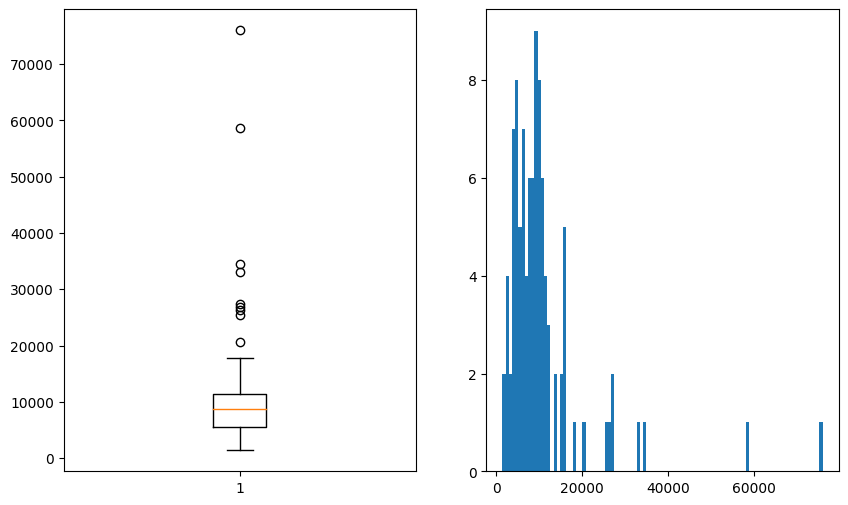

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(10,6))
axs[0].boxplot(price_lst);
axs[1].hist(price_lst, bins=100);

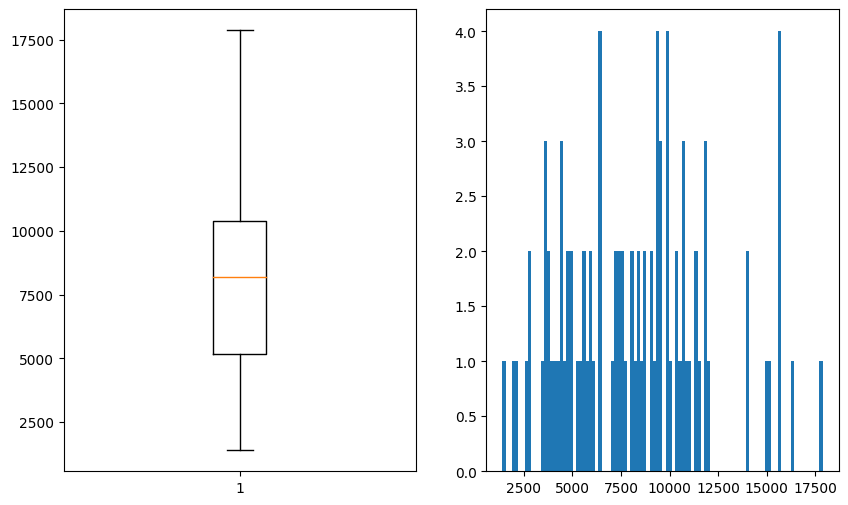

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(10,6))
axs[0].boxplot(removed_arr);
axs[1].hist(removed_arr, bins=100);


In [195]:
def get_outlier(price_arr, weight=1.5):
  # target 값과 상관관계가 높은 열을 우선적으로 진행
    quantile_25 = np.percentile(price_arr, 25)
    quantile_75 = np.percentile(price_arr, 75)

    IQR = quantile_75 - quantile_25
    IQR_weight = IQR*weight
  
    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight
  
    price_arr = price_arr[(price_arr >=lowest) & (price_arr <= highest)]
    return price_arr

In [196]:
get_outlier(price_arr)

array([ 8330,  8200,  6100,  6500,  5100, 19500, 12000, 11900,  4550,
        4500, 27200, 10980, 30170,  4600, 23600,  1250,  2880,  7900,
        6400,  1000, 12000, 14900,  8000,  2830,  5300,  6090, 17900,
       23600,  1300, 19900,  6900, 13900,  5100, 12700,  7900,   640,
        8160,  1000, 12200, 12500, 21920,  1800,  5900,  8000, 13500,
        2610,  5580,  1560,  2920,  4500,   840,  6720,   890,  6410,
       27200,  8320,  6900,  6400,  7000,  8100, 20020,  7900, 30170,
        6150, 17900,  5370,  6930,  8000,  7000,  5580,   890,  3170,
        8070,  7350,  8400,   890,  1500,  6440, 23440,  4600, 15500,
        5580,  6700, 23200, 16900,  8500, 21000,  8300, 18740,   800,
        3190,  5000, 11360,  7460, 19900, 10200,  5300,   840,  1920])

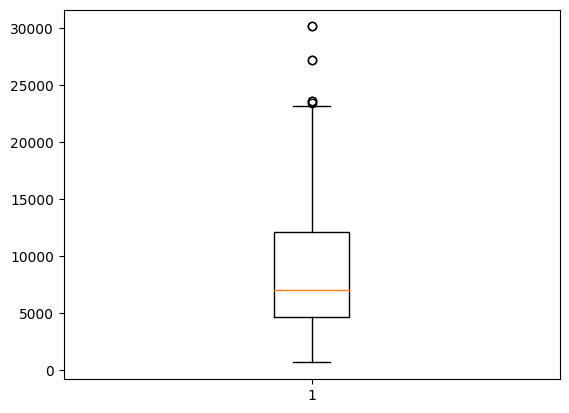

In [197]:
plt.boxplot(get_outlier(price_arr));

In [130]:
arr = price_arr

def remove_outliers(arr) :
    mean = arr.mean()
    std = arr.std()
    upper_bound = mean + (3 * std)
    lower_bound = mean - (3 * std)
    return (upper_bound,lower_bound)

upper_bound,lower_bound = remove_outliers(arr)

removed_arr = arr[(arr <=upper_bound) & (arr >= lower_bound)]
print(arr[(arr >=upper_bound) | (arr <= lower_bound)])
print(removed_arr.shape)
int(removed_arr.mean())

[160000 154000 200000]
(97,)


16774